<center><h1><bold>Classification of Wildfire Casuses</bold></h1></center>

# R4 - Baseline Training and Evaluation using k- Nearest Neighbor

#### Importing necessary python libraries required for data wrangling
- <code>Pandas</code>: for data structutres and tools for effective data cleaning
<code>numpy</code>: for numerical and array-based operations
- <code>sklearn</code>: open source machine learning library for python
- <code>Matplotlib</code>: allow for graphical representation of the data set features

From <code>sklearn</code> we import
- <code>KNeighborsClassifier</code>: to manually compute distances and manage neighbors.
- <code>preprocessing</code>: to transform categorical features to numerical values for decision tree classifier
- <code>model_selection</code>: to split the data into training and test sets
- <code>metrics</code>: for the evaluation of the model performance

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

<h2>Downloading the Data</h2>
    To download the data, we will use pandas library to read it directly into a dataframe from a CSV file.

In [2]:
wildfire_data = pd.read_csv('E:\\DL\\group-coursework-bots-ahead\\data\\wildifire2.csv')
wildfire_data.head()

,Unnamed: 0,FIRE_DAY,FIRE_MONTH,Fire_Duration,FIRE_SIZE,STATE,LATITUDE,LONGITUDE,NWCG_GENERAL_CAUSE,NWCG_CAUSE_CLASSIFICATION
0,0,Wednesday,February,0,0.10,CA,40.036944,-121.005833,Power generation/transmission/distribution,Human
1,1,Wednesday,May,0,0.25,CA,38.933056,-120.404444,Natural,Natural
2,2,Monday,May,0,0.10,CA,38.984167,-120.735556,Debris and open burning,Human
3,3,Monday,June,5,0.10,CA,38.559167,-119.913333,Natural,Natural
4,4,Monday,June,5,0.10,CA,38.559167,-119.933056,Natural,Natural


<h2>Preprocessing</h2>
Selecting the features to be used in the classifier
<ul>
    <li> <b> X </b> as the <b> Feature Matrix </b> (data of <code>wildfire_data</code>) </li>
    <li> <b> Y </b> as the <b> response vector </b> (target) </li>
</ul>

The algorithm will be implemented without the feature <code>NWCG_GENERAL_CAUSE</code><br>
- We are excluding it because the feature contians our similar data to our target binary class which are the values <b>natural</b> and <b>human<b>

In [14]:
# excluding the target variable from our selection
X = wildfire_data[['FIRE_DAY','FIRE_MONTH', 'Fire_Duration', 'FIRE_SIZE', 'STATE', 'LATITUDE', 'LONGITUDE']].values
X[0:6]

array([['Wednesday', 'February', 0, 0.1, 'CA', 40.03694444,
        -121.00583333],
       ['Wednesday', 'May', 0, 0.25, 'CA', 38.93305556, -120.40444444],
       ['Monday', 'May', 0, 0.1, 'CA', 38.98416667, -120.73555556],
       ['Monday', 'June', 5, 0.1, 'CA', 38.55916667, -119.91333333],
       ['Monday', 'June', 5, 0.1, 'CA', 38.55916667, -119.93305556],
       ['Wednesday', 'June', 1, 0.1, 'CA', 38.63527778, -120.10361111]],
      dtype=object)

Some features in this dataset are categorical, such as **FIRE_DAY**, **FIRE_MONTH** and **STATE**. Sklearn KNearestClassifier does not handle categorical variables.
 - We will transform the 3 features into numerical data using the <code>LabelEncoder()</code> from sklearn's preprocessing

In [15]:
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
states = ['CA', 'NM', 'OR', 'NC', 'WY', 'WA', 'MT', 'UT', 'AZ', 'SD', 'NV',
       'ID', 'MN', 'SC', 'OK', 'CO', 'MO', 'NE', 'MI', 'KY', 'OH', 'IN',
       'VA', 'IL', 'TN', 'GA', 'AK', 'TX', 'ND', 'WV', 'WI', 'NH', 'PA',
       'AR', 'FL', 'MS', 'AL', 'ME', 'VT', 'LA', 'KS', 'MD', 'NJ', 'MA',
       'NY', 'HI', 'CT', 'PR', 'RI', 'IA', 'DE']

le_days = preprocessing.LabelEncoder()
le_month = preprocessing.LabelEncoder()
le_states = preprocessing.LabelEncoder()

# Fit the LabelEncoder to these categories
le_days.fit(days)
le_month.fit(months)
le_states.fit(states)

# Transform the column in the array X (e.g., column index 4)
X[:, 0] = le_days.transform(X[:, 0])
X[:, 1] = le_month.transform(X[:, 1])
X[:, 4] = le_states.transform(X[:, 4])

Viewing the array after the data has been trasformed

In [16]:
X[0:6]

array([[6, 3, 0, 0.1, 4, 40.03694444, -121.00583333],
       [6, 8, 0, 0.25, 4, 38.93305556, -120.40444444],
       [1, 8, 0, 0.1, 4, 38.98416667, -120.73555556],
       [1, 6, 5, 0.1, 4, 38.55916667, -119.91333333],
       [1, 6, 5, 0.1, 4, 38.55916667, -119.93305556],
       [6, 6, 1, 0.1, 4, 38.63527778, -120.10361111]], dtype=object)

#### Storing the target varible in Y

In [17]:
Y = wildfire_data['NWCG_CAUSE_CLASSIFICATION']
Y[0:6]

0      Human
1    Natural
2      Human
3    Natural
4    Natural
5    Natural
Name: NWCG_CAUSE_CLASSIFICATION, dtype: object

Dropping the 'FIRE_DAY' from the dataset as it doesn't possess any importance (03_DecisionTree) 

In [18]:
X = np.delete(X, 0, axis=1)
print(X[0:6])

[[3 0 0.1 4 40.03694444 -121.00583333]
 [8 0 0.25 4 38.93305556 -120.40444444]
 [8 0 0.1 4 38.98416667 -120.73555556]
 [6 5 0.1 4 38.55916667 -119.91333333]
 [6 5 0.1 4 38.55916667 -119.93305556]
 [6 1 0.1 4 38.63527778 -120.10361111]]


## Training and Testing
Now <code>train_test_split</code> will usually return 4 different parameters. We label them:<br>
X_train, X_test, Y_train, Y_test <br> <br>
The <code>train_test_split</code> will need the parameters: <br>
X, Y, test_size=0.3, and random_state=42. <br> <br>
- The <b>X</b> and <b>Y</b> are the arrays required before the split<br> 
- The <b>test_size</b> represents the ratio of the testing dataset; so 30% of the data will be used for testing<br>
- The <b>random_state</b> ensures that we obtain the same splits.
- We also use the <b>stratify</b> parameter to make sure that the data is evenly distributed

In [19]:
# stratify to ensure data is distributed evenly
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

### We will look at the Training and Test sets to ensure that the dimensions match

In [20]:
print('Shape of X Train Set:', X_train.shape)
print('Shape of Y Train Set:', Y_train.shape)

Shape of X Train Set: (655704, 6)
Shape of Y Train Set: (655704,)


## Feature Scaling

### Now we will normalize the features using Min-Max Scaling

In [21]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelling
### 1. Parameter Search Configuration
- We will use `RandomizedSearch with Cross-Validation` to optimize hyperparameters for the K- Nearest Neighbor model.
- The search will explore different combinations of:
  - **n_neighbors**: Values of K, ranging fro 1 to 20
  - **weights**: **uniform** assigns equal weight to each neighbor
       -**distance** gives closer neighbors more influence 
  - **metric**: Different disatnce metrics to measure closeness in K-NN
     - *euclidean*: Common distance metric and measures the 'straight-line' distance between points
      - *Manhattan*: Calculates the absolute differences along each feature, resembling how one would move along a grid
       - *Minkowski*: Behaves either as Euclidean or Manhattan depending on the value of a parameter

In [22]:
param_dist = {
    'n_neighbors': np.arange(1,21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

### 2. Parameter Search Process
- Using `RandomizedSearchCV` to find optimal parameters through:
  - **10 iterations** of different parameter combinations
  - **5-fold cross-validation** to ensure robust parameter selection
  - Each parameter set is evaluated on different data splits to avoid selection bias

In [23]:
#Creating the K-NN model
knn = KNeighborsClassifier()
#Randomized search with 5- fold cross-validation
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, cv=5, scoring = 'accuracy',n_iter=10, random_state=42)
random_search.fit(X_train_scaled, Y_train)
#Finding Best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best Cross-Validation Accuracy: ", random_search.best_score_)

Best Parameters:  {'weights': 'distance', 'n_neighbors': 17, 'metric': 'manhattan'}
Best Cross-Validation Accuracy:  0.9216765488761869


## Final Model Implementation

### 1. Creating Optimized Model
Using our discovered best parameters with the randomized search, we can proceed to train the K-NN model using the optimized parameters and then evaluate it on the test set where **weights** : *distance*, **n_neighbors** : *17*, **metric** : *manhattan* and an **accuracy** of 0.92

In [24]:
# Using the best parameters to create the final model
final_knn = KNeighborsClassifier(
    n_neighbors = 17,
    weights = 'distance',
    metric = 'manhattan'
)

#### Next, we will fit the data with the training feature matrix <b> X_train </b> and training  response vector <b> Y_train </b>

In [25]:
# Training the optimized model to the training data
final_knn.fit(X_train_scaled,Y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=17, weights='distance')

## Prediction
- Let's make some <b>predictions</b> on the testing dataset and store it into a variable called <code>Y_pred</code>.

In [26]:
Y_pred = final_knn.predict(X_test_scaled)

#### Printing the prediction and the test data to visually compare results of the first 5 and last 5 values

In [27]:
print(Y_pred [0:5])
print(Y_test [0:5])

['Human' 'Human' 'Human' 'Human' 'Human']
167511    Human
333524    Human
416014    Human
180646    Human
897540    Human
Name: NWCG_CAUSE_CLASSIFICATION, dtype: object


In [ ]:
print(Y_pred [-5:])
print(Y_test [-5:])

['Natural' 'Human' 'Human' 'Natural' 'Natural']
613183      Human
323399      Human
72214       Human
92804     Natural
74358     Natural
Name: NWCG_CAUSE_CLASSIFICATION, dtype: object


In [29]:
# Evaluating the accuracy on test set
test_accuracy = final_knn.score(X_test_scaled, Y_test)
print("Test set accuracy: ", test_accuracy)

Test set accuracy:  0.9229759159620804


## Model Evaluation
- **Accuracy Classification Score**: Measures the proportion of correct predictions
  - In binary classification (Human/Natural), it shows how often our model is correct
  - Perfect accuracy (1.0) means all predictions match true labels
  - However, with imbalanced classes, accuracy alone can be misleading

- **Classification Report**: Provides detailed per-class performance metrics
  - Precision: Proportion of correct positive predictions
  - Recall: Proportion of actual positives correctly identified
  - Support: Number of samples for each class

In [30]:
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy : ", accuracy)
print("Classification Report: \n", classification_report(Y_test,Y_pred))

Accuracy :  0.9229759159620804
Classification Report: 
               precision    recall  f1-score   support

       Human       0.94      0.97      0.95    234200
     Natural       0.81      0.70      0.75     46816

    accuracy                           0.92    281016
   macro avg       0.88      0.83      0.85    281016
weighted avg       0.92      0.92      0.92    281016



### Observations:
- The model have an accuracy of 0.92.
- It performs generally very well in prediciting **human** causes. It shows excellent  <code>recall</code> : 0.97 and high <code>f1-score</code>: 0.95 indicating a balanced performance for Human causes. 
- It is not as accurate when predicting **natural** causes and has a <code>recall</code>: 0.70 and <code>f1 score</code> of 0.75.

## Confusion Matrix

In [45]:
cm = confusion_matrix(Y_test, Y_pred)

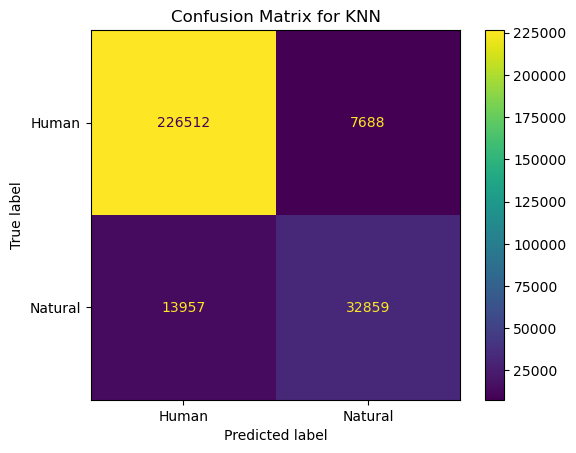

In [61]:
# Plotting the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(final_knn, X_test_scaled,Y_test, cmap='viridis')
plt.title('Confusion Matrix for KNN')
plt.show()

## Now we will apply SMOTE , which will generate synthetic samples for the training data to balance the classes.

In [31]:
# Applying SMOTE
smote = SMOTE(random_state=42)
X_train_sm, Y_train_sm = smote.fit_resample(X_train, Y_train)

In [52]:
# Printing the output after SMOTE
print("Shape of X_train after SMOTE: ", X_train_sm.shape)
print("Shape of Y_train after SMOTE: ", Y_train_sm.shape)

Shape of X_train after SMOTE:  (1092934, 6)
Shape of Y_train after SMOTE:  (1092934,)


In [34]:
scaler = MinMaxScaler()
X_train_scaled_sm = scaler.fit_transform(X_train_sm)
X_test_scaled_sm = scaler.transform(X_test)

In [35]:
param_dist1 = {
    'n_neighbors': np.arange(1,21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [36]:
#Creating the K-NN model
knn1 = KNeighborsClassifier()
#Randomized search with 5- fold cross-validation
random_search_sm = RandomizedSearchCV(estimator=knn1, param_distributions=param_dist1, cv=5, scoring = 'accuracy',n_iter=10, random_state=42)
random_search_sm.fit(X_train_scaled_sm, Y_train_sm)
#Finding Best parameters and best score
print("Best Parameters: ", random_search_sm.best_params_)
print("Best Cross-Validation Accuracy: ", random_search_sm.best_score_)

Best Parameters:  {'weights': 'distance', 'n_neighbors': 8, 'metric': 'manhattan'}
Best Cross-Validation Accuracy:  0.9089487585754098


In [37]:
# Using the best parameters to create the final model
final_knn_sm = KNeighborsClassifier(
    n_neighbors = 8,
    weights = 'distance',
    metric = 'manhattan'
)

In [38]:
# Training the optimized model to the training data
final_knn_sm.fit(X_train_scaled_sm,Y_train_sm)

KNeighborsClassifier(metric='manhattan', n_neighbors=8, weights='distance')

In [40]:
Y_pred_sm = final_knn_sm.predict(X_test_scaled_sm)

In [41]:
print(Y_pred_sm [0:5])
print(Y_test [0:5])

['Human' 'Human' 'Human' 'Human' 'Human']
167511    Human
333524    Human
416014    Human
180646    Human
897540    Human
Name: NWCG_CAUSE_CLASSIFICATION, dtype: object


In [42]:
print(Y_pred_sm [-5:])
print(Y_test [-5:])

['Natural' 'Human' 'Natural' 'Natural' 'Natural']
613183      Human
323399      Human
72214       Human
92804     Natural
74358     Natural
Name: NWCG_CAUSE_CLASSIFICATION, dtype: object


In [53]:
accuracy_sm = accuracy_score(Y_test, Y_pred_sm)
print("Accuracy : ", accuracy_sm)
print("Classification Report: \n", classification_report(Y_test,Y_pred_sm))

Accuracy :  0.8932907734790901
Classification Report: 
               precision    recall  f1-score   support

       Human       0.96      0.91      0.93    234200
     Natural       0.64      0.82      0.72     46816

    accuracy                           0.89    281016
   macro avg       0.80      0.87      0.83    281016
weighted avg       0.91      0.89      0.90    281016



### Observations after SMOTE:
- The model have an accuracy of 0.89.
- It performs generally very well in prediciting **human** causes. It shows excellent  <code>recall</code> : 0.91 and high <code>f1-score</code>: 0.93 indicating a balanced performance for Human causes. 
- It is not as accurate when predicting **natural** causes and has a <code>recall</code>: 0.82 and <code>f1 score</code> of 0.72. But still, we can see that, the <code>recall</code> of **Natural** has increased after using SMOTE

In [54]:
cm1 = confusion_matrix(Y_test, Y_pred_sm)

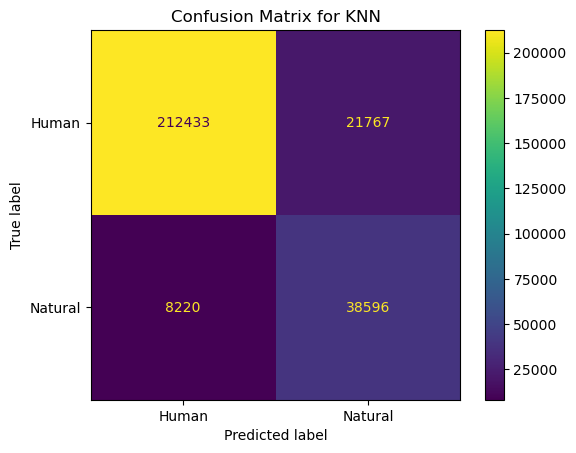

In [59]:
# Plotting the confusion matrix
disp1 = ConfusionMatrixDisplay.from_estimator(final_knn_sm, X_test_scaled_sm,Y_test, cmap='viridis')
plt.title('Confusion Matrix for KNN')
plt.show()

## Visualisation using Dimensionality Reduction Techniques
As the dataset has many features, we use <code>Principal Component Analysis(PCA)</code> to reduce it to two dimensions and visualize it.

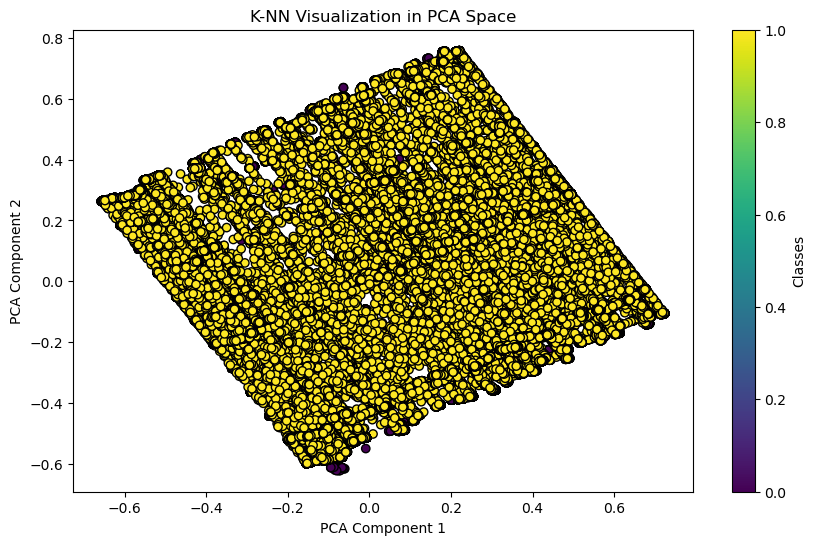

In [62]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Reducing the dimensions to 2 with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled_sm)

# Fit the K-NN model on PCA-transformed data
knn_pca = KNeighborsClassifier(
    n_neighbors=8, 
    weights= 'distance', 
    metric='manhattan')
knn_pca.fit(X_pca, Y_train_sm)

# Encoding Y_train into numerical values
le = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train_sm)

# Plotting the PCA transformed points with labels
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=Y_train_encoded, cmap='viridis', edgecolor='k')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-NN Visualization in PCA Space')
plt.colorbar(label='Classes')
plt.show()

## Key Findings
From this PCA-based scatter plot, we can observe that how the data points in the dataset are distributed across two principal components. 
- Most of the data points are in a single class. This indicates a class imbalance, with one class dominating the dataset.
- The data points are spread out but seem densely packed in the PCA space.This may reflect the complexity of the data.
- Since K-NN relies on distance to classify points, this lack of separation and overlap in the PCA space could lead to mis classifications.

The rectangular grid like distribution of points suggest that PCA componenets capture some structured variation in the original, features, but they are mostly dominated by one class, indicating that the first two principal components may not be sufficient to capture the variance for classification purposes. 

* For that we will be using 3D plot of the first three principal components

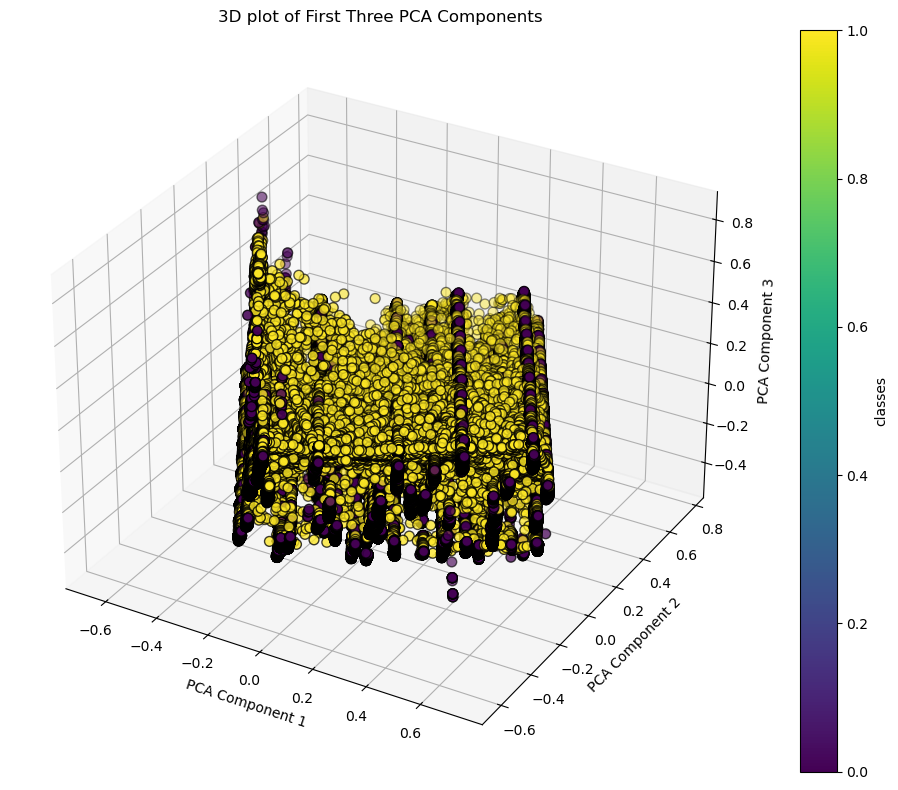

In [63]:
from mpl_toolkits.mplot3d import Axes3D
# Fitting teh PCA with 3 components on the training data
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scaled_sm)
X_test_pca = pca.transform(X_test_scaled_sm)

# 3-D plot for the first three principal components
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection = '3d')
sc = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=Y_train_encoded,cmap='viridis', edgecolor='k', s=50)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D plot of First Three PCA Components') 
plt.colorbar(sc, label='classes')
plt.tight_layout()
plt.show()

## Key Findings
From this 3-D plot, we can observe that:
- Most of the data points appear to be a single dominant classes, while the minority class seems sparse and scattered. This indicate an imbalanced dataset, where one class significantly outweighs the others.
- the plot shows a high overlap of teh points , meaning teh classes are not clearly separable.
- The points seems to be "stacked", implying that some componenets capture only limited variance.
- From this, we can see that more information or complex transformations may be necessary for clearer separability among classes.